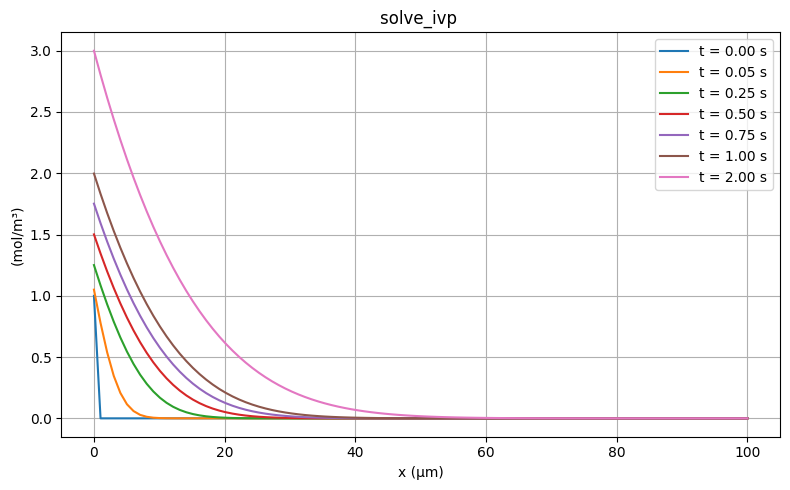

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# 模擬參數
D = 1e-10        # 擴散係數 (m^2/s)
L = 1e-4         # 膜厚度 (m)
Nx = 100         # 空間格點數
x = np.linspace(0, L, Nx)
dx = x[1] - x[0]

# 初始濃度：全部為 0
C_init = np.zeros(Nx)

# 邊界條件：左邊固定 C=1.0，右邊固定 C=0.0
def apply_boundary(C):
    C[0] = 1.0
    C[-1] = 0.0
    return C

# 建立二階微分矩陣 (中央差分)
def diffusion_rhs(t, C):
    dCdt = np.zeros_like(C)
    dCdt[1:-1] = D * (C[2:] - 2*C[1:-1] + C[:-2]) / dx**2
    dCdt = apply_boundary(dCdt)  # 保持邊界條件
    return dCdt

# 求解時間範圍
t_span = (0, 2.0)  # 模擬 2 秒
t_eval = np.linspace(t_span[0], t_span[1], 400)

# 解 ODE 系統
sol = solve_ivp(diffusion_rhs, t_span, apply_boundary(C_init), t_eval=t_eval, method='RK45')

# 繪圖：選擇幾個時間點畫出濃度分佈
time_indices = [0, 10, 50, 100, 150, 199,399]
plt.figure(figsize=(8, 5))
for idx in time_indices:
    plt.plot(x * 1e6, sol.y[:, idx], label=f't = {sol.t[idx]:.2f} s')

plt.xlabel('x (μm)')
plt.ylabel('(mol/m³)')
plt.title('solve_ivp ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

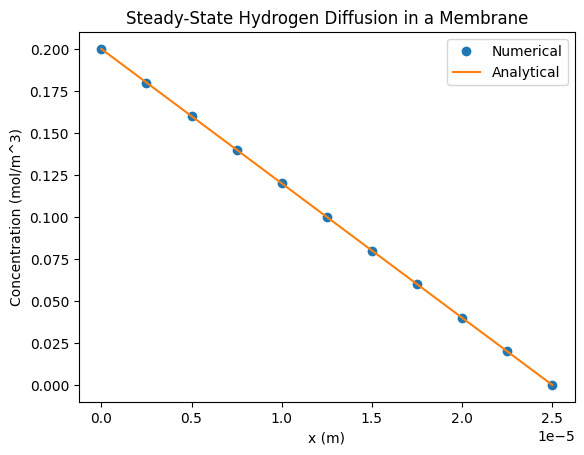

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Given parameters
L = 25e-6          # Membrane thickness (m)
D = 2e-8         # Diffusion coefficient (m^2/s) - for a steady-state solution, the actual value of D is not critical unless there's a flux calculation
C_in = 0.2       # Inlet concentration (mol/m^3)
C_out = 0.0      # Outlet concentration (mol/m^3)

# Number of discretization points (including boundaries)
N = 10
dx = L / N

# Create the array for x positions
x = np.linspace(0, L, N+1)

# --- Set up the coefficient matrix A and right-hand side b ---
A = np.zeros((N+1, N+1))
b = np.zeros(N+1)

# 1) Boundary conditions:
#    C(0) = C_in  --> row 0:  A[0,0] = 1; b[0] = C_in
A[0, 0] = 1.0
b[0] = C_in

#    C(L) = C_out --> row N:  A[N,N] = 1; b[N] = C_out
A[N, N] = 1.0
b[N] = C_out

# 2) Interior points (finite-difference equation):
#    C_{i+1} - 2*C_i + C_{i-1} = 0
for i in range(1, N):
    A[i, i-1] = -1.0
    A[i, i]   =  2.0
    A[i, i+1] = -1.0
    b[i] = 0.0

# Solve the system A * C = b
C_numeric = np.linalg.solve(A, b)

# Analytical solution for comparison:
C_analytic = C_in + (C_out - C_in)*x/L

# --- Plot the results ---
plt.figure()
plt.plot(x, C_numeric, 'o', label='Numerical')
plt.plot(x, C_analytic, label='Analytical')
plt.xlabel('x (m)')
plt.ylabel('Concentration (mol/m^3)')
plt.title('Steady-State Hydrogen Diffusion in a Membrane')
plt.legend()
plt.show()

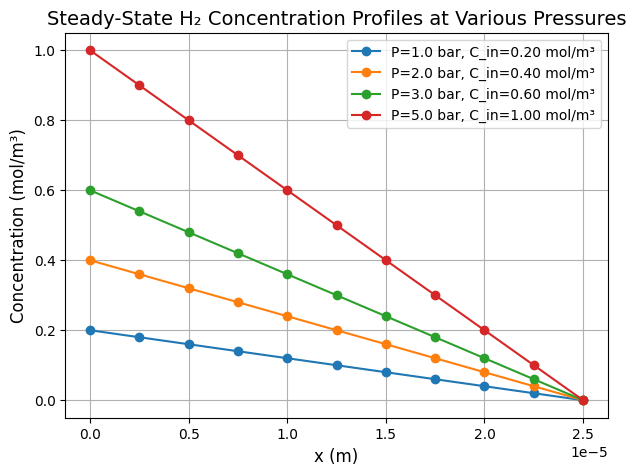

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------------
# Given / Problem parameters
# ----------------------------------------------------------------------------
L = 25e-6          # Membrane thickness (m)
D = 2e-8         # Diffusion coefficient (m^2/s) - relevant if calculating flux
N = 10           # Number of divisions in the membrane

# From the table, the inlet concentrations vary with pressure; outlet is 0 in all cases
# (OperatingPressure [bar], H2_in [mol/m^3])
scenarios = [
    (1.0, 0.20),
    (2.0, 0.40),
    (3.0, 0.60),
    (5.0, 1.00)
]

C_out = 0.0   # H2 Concentration out (mol/m^3), same for all scenarios

# Build the spatial grid
dx = L / N
x = np.linspace(0, L, N + 1)

# ----------------------------------------------------------------------------
# Function to solve the steady-state 1D diffusion equation numerically
# ----------------------------------------------------------------------------
def solve_diffusion(c_in, c_out, L, N):
    """
    Solve -D d^2C/dx^2 = 0 with boundary conditions:
        C(0) = c_in,  C(L) = c_out
    using a finite-difference approach.
    """
    # Set up the coefficient matrix A and right-hand side b for (N+1) grid points
    A = np.zeros((N + 1, N + 1))
    b = np.zeros(N + 1)
    
    # Boundary conditions
    # At x=0 (i=0): C(0) = c_in
    A[0, 0] = 1.0
    b[0] = c_in
    
    # At x=L (i=N): C(N) = c_out
    A[N, N] = 1.0
    b[N] = c_out
    
    # Interior points: -1, 2, -1 structure
    for i in range(1, N):
        A[i, i-1] = -1.0
        A[i, i]   =  2.0
        A[i, i+1] = -1.0
        # b[i] = 0.0  (already zero by initialization)
    
    # Solve the linear system A * C = b for the unknown concentrations
    C = np.linalg.solve(A, b)
    return C

# ----------------------------------------------------------------------------
# Solve for each scenario and plot
# ----------------------------------------------------------------------------
plt.figure(figsize=(7,5))

for (pressure, c_in) in scenarios:
    # Solve for this inlet concentration
    C_numeric = solve_diffusion(c_in, C_out, L, N)
    
    # Plot the numerical result
    plt.plot(x, C_numeric, marker='o', label=f'P={pressure:.1f} bar, C_in={c_in:.2f} mol/m³')

# Cosmetic finishing touches
plt.xlabel('x (m)', fontsize=12)
plt.ylabel('Concentration (mol/m³)', fontsize=12)
plt.title('Steady-State H₂ Concentration Profiles at Various Pressures', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()